In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from ipynb.fs.full.plotter_class import Plotter
from ipynb.fs.full.time_series_data import TimeSeriesData
from ipynb.fs.full.dataset_creator import SupervisedDatasetCreator
from ipynb.fs.full.dataset_scaler_manager import DataScalerManager
from ipynb.fs.full.lstm import LSTMModel

In [10]:
class MultivariadoPipeline:
    def __init__(self, config):
        self.config = config
        self.data_scaler_manager = DataScalerManager()
        self.ts_data = TimeSeriesData(self.config['data_path'], self.config['file_name'])
        self.column_target = self.config['column_target']
        self.lstm_model = None
        self.scaler = None
        self.data = None
        self.dataset = None
        self.y_test_pred = None
        
    def create_supervised_data(self):
        preprocessor = SupervisedDatasetCreator(self.config['input_length'], self.config['output_length'])
        x_train, y_train = preprocessor.create_supervised_dataset(self.data['train'].values)
        x_val, y_val = preprocessor.create_supervised_dataset(self.data['val'].values)
        x_test, y_test = preprocessor.create_supervised_dataset(self.data['test'].values)

        self.data.update({
            'x_train': x_train, 'y_train': y_train,
            'x_val': x_val, 'y_val': y_val,
            'x_test': x_test, 'y_test': y_test
        })
                                
    def build_model(self):
        input_shape = (self.data['x_train'].shape[1], self.data['x_train'].shape[2])
        lstm_model = LSTMModel(n_units=self.config['n_units'], input_shape=input_shape, output_shape=self.config['output_length'], learning_rate=self.config['learning_rate'])
        self.lstm_model = lstm_model.model   
        
    def drop_column(self, column):
        return self.dataset.drop(column, axis=1)
    
    def drop_columns(self, columns):
        for column in columns:
            self.dataset = self.drop_column(column)
        
    def evaluate_model(self):
        rmse_train = self.lstm_model.evaluate(self.data['x_train'], self.data['y_train'], verbose=0)
        rmse_val = self.lstm_model.evaluate(self.data['x_val'], self.data['y_val'], verbose=0)
        rmse_test = self.lstm_model.evaluate(self.data['x_test'], self.data['y_test'], verbose=0)

        print('RMSE Comparison:')
        print(f'  RMSE Train: {rmse_train:.3f}')
        print(f'  RMSE Val: {rmse_val:.3f}')
        print(f'  RMSE Test: {rmse_test:.3f}')
    
    def feature_engineering(self):
        w_dir = self.dataset['wd (deg)'] * np.pi / 180    
        Wx = self.dataset['wv (m/s)'] * np.cos(w_dir)
        Wy = self.dataset['wv (m/s)'] * np.sin(w_dir)
        
        self.dataset = self.dataset.drop(columns=['wd (deg)', 'wv (m/s)', 'max. wv (m/s)'])    
        self.dataset['Wx'] = Wx
        self.dataset['Wy'] = Wy
        
    def plot_datasets(self):
        """
        Plots subplots for each variable in the dataset with corresponding legends and titles.
        """
        num_variables = len(self.data['train'].columns)
        variables = self.data['train'].columns
        
        fig, axes = plt.subplots(num_variables, 1, figsize=(12, 4 * num_variables), sharex=True)
        
        if num_variables == 1:
            axes = [axes]  
        
        for i, var in enumerate(variables):
            ax = axes[i]
            ax.plot(self.data['train'][var], label='Train')
            ax.plot(self.data['val'][var], label='Val')
            ax.plot(self.data['test'][var], label='Test')
            
            ax.set_title(f'{var} over Time')
            ax.set_ylabel(var)
            ax.legend()
        
        axes[-1].set_xlabel('Time')
        plt.tight_layout()
        plt.show()
    
            
            
    
    # def plot_datasets(self):
    #     plotter = Plotter()               
    #     plotter.plot(self.data['train'], label='Train')
    #     plotter.plot(self.data['val'], label='Val')
    #     plotter.plot(self.data['test'], label='Test')
    #     plotter.configure(title='Weather Data', ylabel='Temperature (°C)')
    #     plotter.show() 
        
    # def plot_predictions(self):
    #     plotter = Plotter()
    #     plotter.plot(self.data['test'].values, label='True')  
    #     plotter.plot(self.y_test_pred, label='Predicted')
    #     plotter.configure(title='True vs Predicted', xlabel='Time Steps', ylabel='Temperature (°C)')
    #     plotter.show()
        
    def plot_predictions(self):
        target_column = self.config['column_target']      
        plotter = Plotter()
        plotter.plot(self.data['test'][target_column].values, label='True')
        plotter.plot(self.y_test_pred, label='Predicted')
        plotter.configure(title=f'True vs Predicted for {target_column}', xlabel='Time Steps', ylabel=target_column)
        plotter.show()
        
    def plot_prediction_errors(self):
        N = len(self.y_test_pred)  
        ndato = np.linspace(1, N, N)

        errores = self.data['y_test'].flatten() - self.y_test_pred
        plt.plot(ndato, errores)
        plt.xlabel('Prediction index')
        plt.ylabel('Prediction error')
        plt.title('Prediction errors')
        plt.show()
        
    def plot_rmse_over_timesteps(self):
        y_test_pred_scaled = self.lstm_model.predict(self.data['x_test'], verbose=0)
        y_test_pred = self.scaler.inverse_transform(y_test_pred_scaled)

        diff_cuad = np.square(self.data['y_test'].squeeze() - y_test_pred)
        proms = np.mean(diff_cuad, axis=0)
        rmse = np.sqrt(proms)

        t = np.linspace(1, self.config['output_length'], self.config['output_length'])
        fig, ax = plt.subplots()
        ax.scatter(t, rmse)
        ax.set_xlabel('Predicted Timestep')
        ax.set_ylabel('RMSE Error (°C)')
        plt.xticks(ticks=t, labels=t)
        plt.grid()
        plt.show()    
        
    def plot_training_history(self, history):
        plotter = Plotter()
        
        plotter.plot(history.history['loss'], label='RMSE Train')
        plotter.plot(history.history['val_loss'], label='RMSE Val')
        plotter.configure(title='Epochs vs RMSE', xlabel='Epochs', ylabel='RMSE')
        plotter.show()  
        
    def predict(self, x):
        y_pred_scaled = self.lstm_model.predict(x, verbose=0)
        y_pred = self.scaler.inverse_transform(y_pred_scaled)
        self.y_test_pred = y_pred.flatten()
        
    def read_file(self):
        ts_data = TimeSeriesData(self.config['data_path'], self.config['file_name'])
        
        if 'columns_dataset' in self.config and self.config['columns_dataset']:
            series = ts_data.df[self.config['columns_dataset']]
        else:
            series = ts_data.df  
        
        self.dataset = series
    
    def split_data(self):
        train, val, test = self.ts_data.train_val_test_split(self.dataset)
        self.data = {'train': train, 'val': val, 'test': test}
        
    def scale_data(self):        
        col_ref = self.dataset.columns.get_loc(self.column_target)  
        scaled_data, self.scaler = self.data_scaler_manager.scale_data(self.data, col_ref)
        self.data.update(scaled_data)
        
    def train_model(self):
        early_stopping = EarlyStopping(patience=6, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-7)

        history = self.lstm_model.fit(
            self.data['x_train'], self.data['y_train'],
            epochs=self.config['epochs'],
            batch_size=self.config['batch_size'],
            validation_data=(self.data['x_val'], self.data['y_val']),
            callbacks=[early_stopping, reduce_lr],
            verbose=2
        )

        self.plot_training_history(history)
                
    def plot_violin_plots(self, x_train=None, x_val=None, x_test=None, y_train=None, y_val=None, y_test=None, feature_names=None, figsize=(12, 4)):
        fig, ax = plt.subplots(figsize=figsize)
        
        if x_train is not None and x_val is not None and x_test is not None and feature_names is not None:
            num_features = x_train.shape[2]
            
            for i in range(num_features):
                train_data = x_train[:, :, i].flatten()
                val_data = x_val[:, :, i].flatten()
                test_data = x_test[:, :, i].flatten()
                
                ax.violinplot(dataset=train_data, positions=[i], showmeans=True, showmedians=True)
                ax.violinplot(dataset=val_data, positions=[i], showmeans=True, showmedians=True)
                ax.violinplot(dataset=test_data, positions=[i], showmeans=True, showmedians=True)
            
            ax.set_xticks(list(range(num_features)))
            ax.set_xticklabels(feature_names, rotation=90)
        
        elif y_train is not None and y_val is not None and y_test is not None:
            ax.violinplot(dataset=y_train.flatten(), positions=[0], showmeans=True, showmedians=True)
            ax.violinplot(dataset=y_val.flatten(), positions=[1], showmeans=True, showmedians=True)
            ax.violinplot(dataset=y_test.flatten(), positions=[2], showmeans=True, showmedians=True)
            
            ax.set_xticks([0, 1, 2])
            ax.set_xticklabels(['Train', 'Val', 'Test'])
        
        else:
            raise ValueError("Invalid input: Provide either x_train, x_val, x_test, and feature_names or y_train, y_val, and y_test.")
        
        ax.autoscale()        
        plt.show()
                    
    def run(self):
        self.read_file()
        self.drop_columns(['datetime'])
        self.feature_engineering()
        self.split_data()
        if self.config['plot']:
            self.plot_datasets()        
        self.create_supervised_data()
        self.scale_data()
        if self.config['plot']:
            self.plot_violin_plots(x_train=self.data['x_train'], x_val=self.data['x_val'], x_test=self.data['x_test'], feature_names=self.dataset.keys())
            self.plot_violin_plots(y_train=self.data['y_train'], y_val=self.data['y_val'], y_test=self.data['y_test'])
        self.build_model()
        self.train_model()
        self.evaluate_model()
        self.predict(self.data['x_test'])
        if self.config['plot']:
            self.plot_predictions()
            if self.config['output_length'] > 1:
                self.plot_rmse_over_timesteps()

In [11]:
# Configuration dictionary
config = {
    'data_path': './../data/',
    'file_name': 'weather_dataset_preprocesado.csv',
    #'columns_dataset': ['datetime', 'p (mbar)', 'T (degC)', 'Tpot (K)'], 
    'column_target': 'T (degC)',   
    'input_length': 24,
    'output_length': 1,
    'epochs': 20,
    'batch_size': 256,
    'learning_rate': 5e-4, #2.8e-4,
    'n_units': 256,
    'plot': True
}

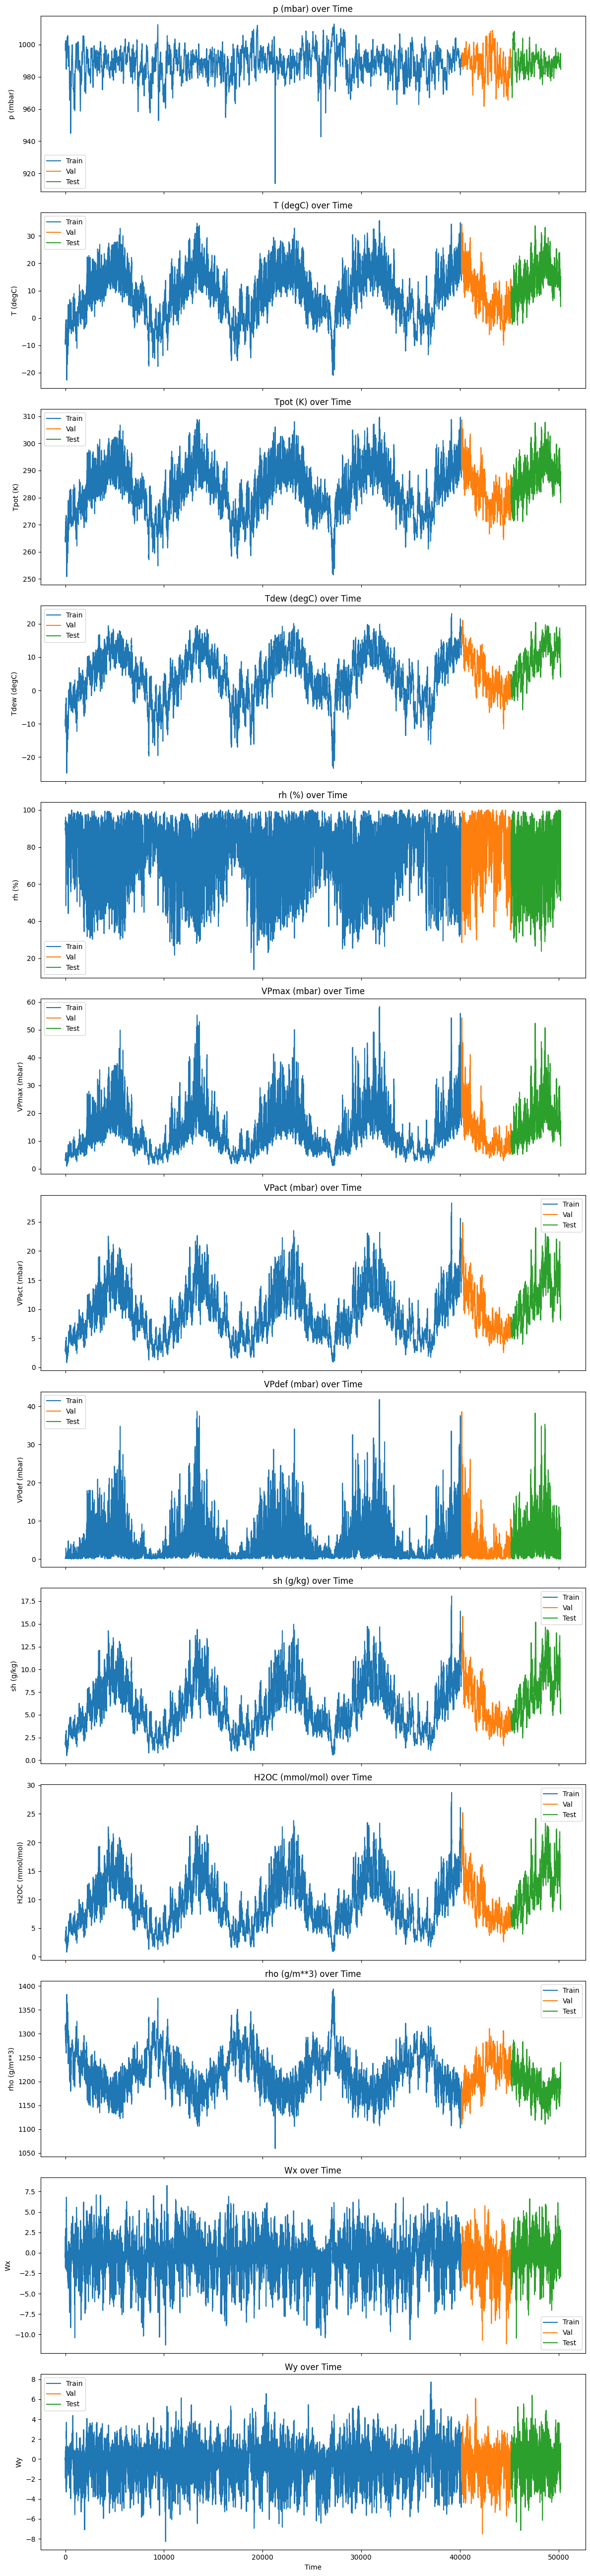

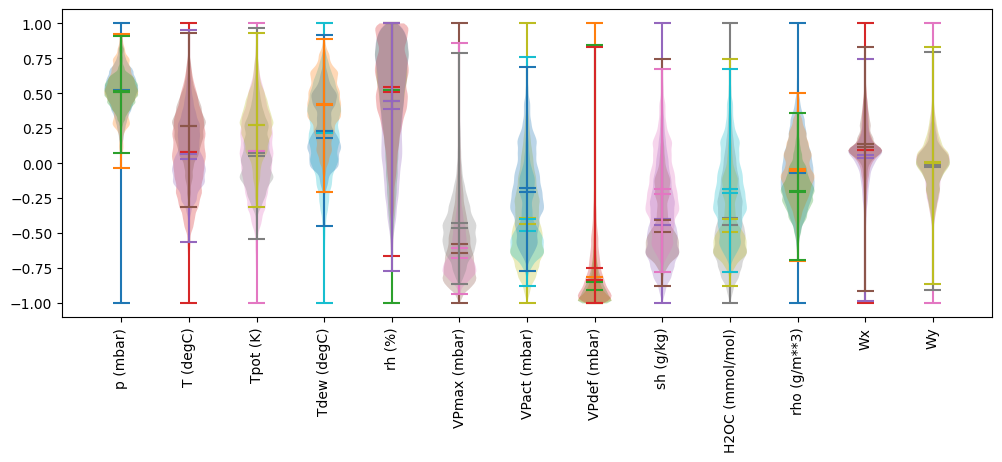

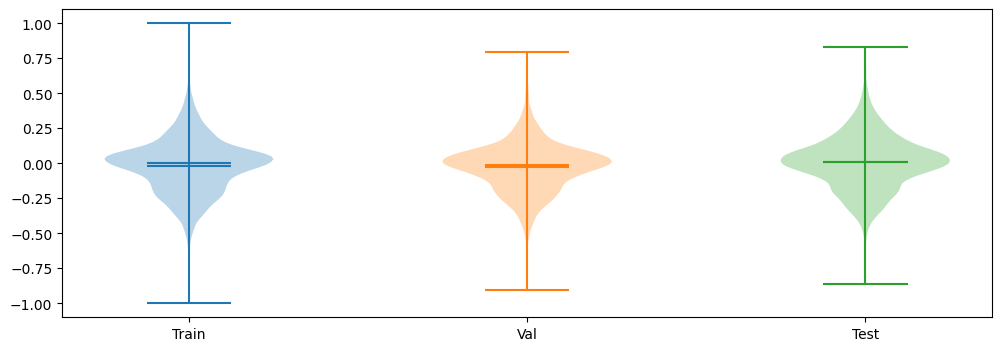

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 - 40s - 257ms/step - loss: 0.1345 - val_loss: 0.1118 - learning_rate: 5.0000e-04
Epoch 2/20
157/157 - 36s - 231ms/step - loss: 0.1155 - val_loss: 0.1058 - learning_rate: 5.0000e-04
Epoch 3/20
157/157 - 37s - 234ms/step - loss: 0.1112 - val_loss: 0.1039 - learning_rate: 5.0000e-04
Epoch 4/20
157/157 - 39s - 248ms/step - loss: 0.1101 - val_loss: 0.1037 - learning_rate: 5.0000e-04
Epoch 5/20
157/157 - 38s - 240ms/step - loss: 0.1094 - val_loss: 0.1036 - learning_rate: 5.0000e-04
Epoch 6/20
157/157 - 39s - 249ms/step - loss: 0.1090 - val_loss: 0.1030 - learning_rate: 5.0000e-04
Epoch 7/20
157/157 - 40s - 257ms/step - loss: 0.1086 - val_loss: 0.1031 - learning_rate: 5.0000e-04
Epoch 8/20
157/157 - 47s - 300ms/step - loss: 0.1083 - val_loss: 0.1026 - learning_rate: 5.0000e-04
Epoch 9/20
157/157 - 42s - 268ms/step - loss: 0.1080 - val_loss: 0.1029 - learning_rate: 5.0000e-04
Epoch 10/20
157/157 - 40s - 252ms/step - loss: 0.1081 - val_loss: 0.1028 - learning_rate: 5.0000e-04

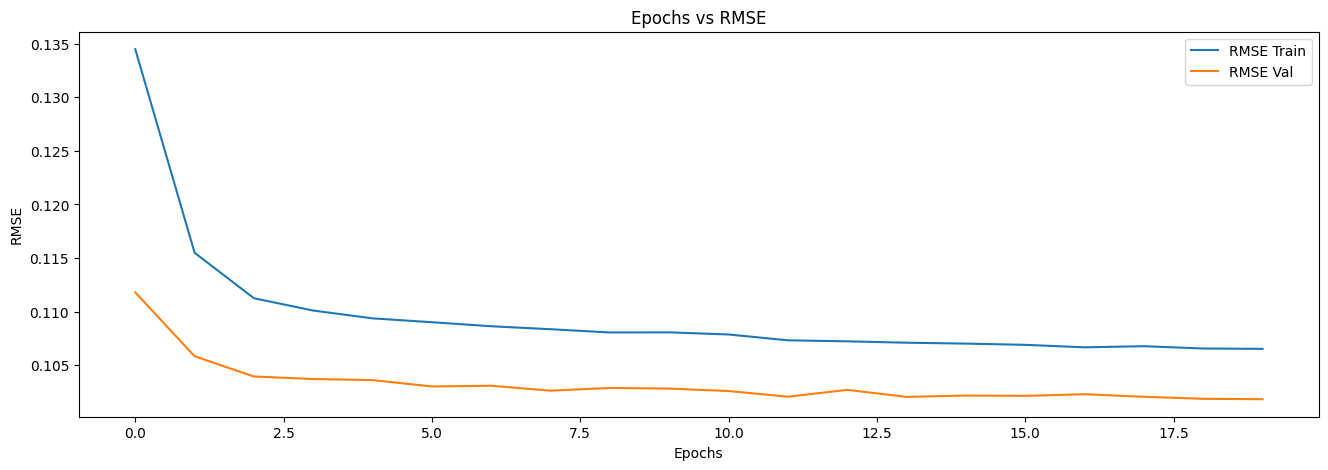

RMSE Comparison:
  RMSE Train: 0.102
  RMSE Val: 0.099
  RMSE Test: 0.108


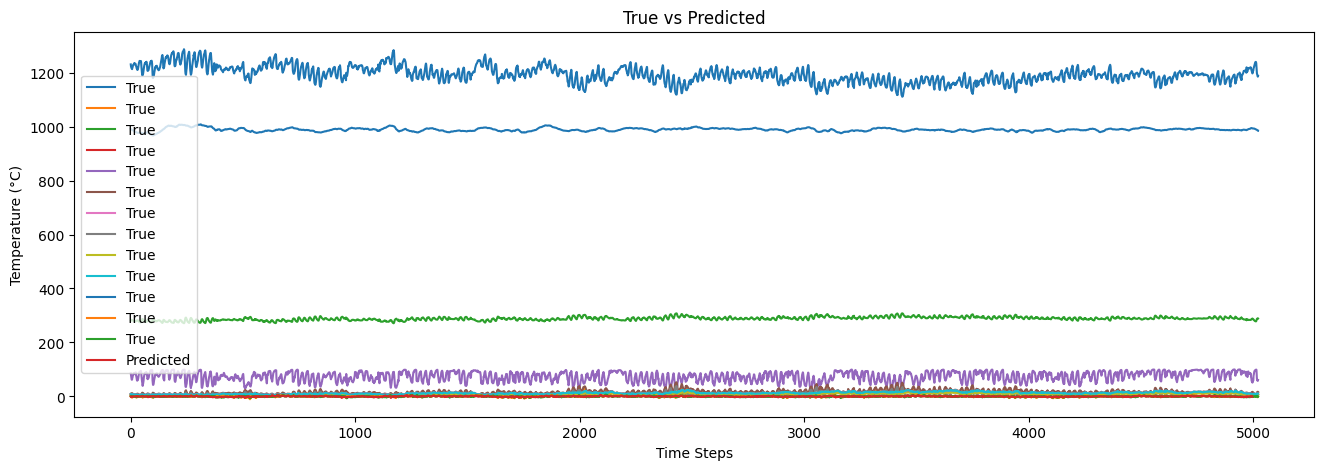

In [12]:
pipeline = MultivariadoPipeline(config)
pipeline.run()

In [21]:
def plot_predictions(data, y_test_pred, target_column):
    target_column = config['column_target']      
    plotter = Plotter()
    plotter.plot(data['test'][target_column].values, label='True')
    plotter.plot(y_test_pred, label='Predicted')
    plotter.configure(title=f'True vs Predicted for {target_column}', xlabel='Time Steps', ylabel=target_column)
    plotter.show()


# def plot_predictions(data, y_test_pred):
#     num_variables = data['test'].shape[1]
#     variables = data['test'].columns
    
#     fig, axes = plt.subplots(num_variables, 1, figsize=(12, 4 * num_variables), sharex=True)
    
#     if num_variables == 1:
#         axes = [axes]  # Ensure axes is iterable if there's only one subplot

#     for i, var in enumerate(variables):
#         ax = axes[i]
#         ax.plot(data['test'][var].values, label='True')
        
#         if y_test_pred.ndim == 1:
#             ax.plot(y_test_pred, label='Predicted')
#         else:
#             ax.plot(y_test_pred[:, i], label='Predicted')
        
#         ax.set_title(f'True vs Predicted for {var}')
#         ax.set_ylabel(var)
#         ax.legend()

#     axes[-1].set_xlabel('Time Steps')
#     plt.tight_layout()
#     plt.show()

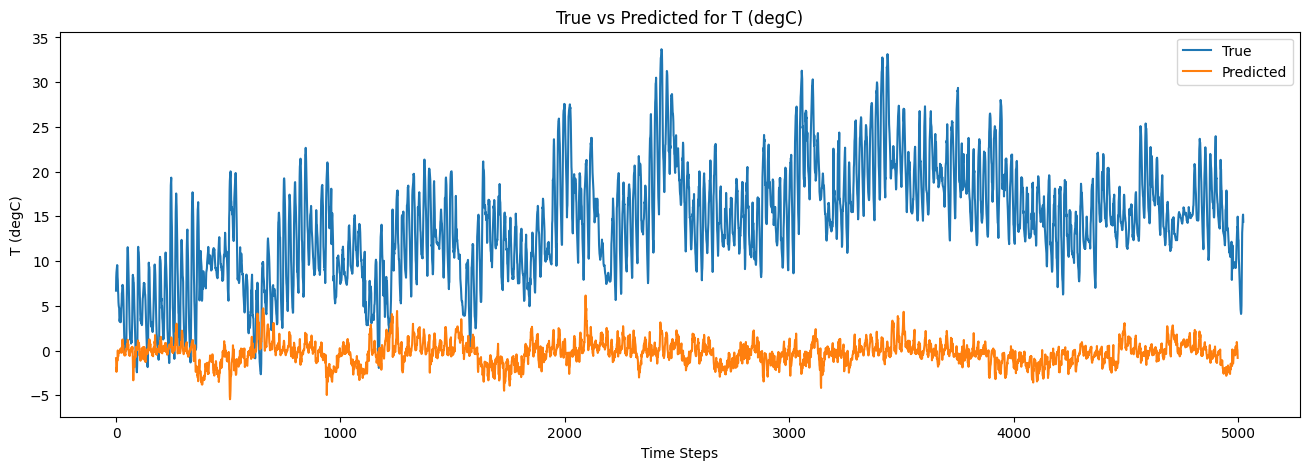

In [22]:
plot_predictions(pipeline.data, pipeline.y_test_pred, config['column_target'])